In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, confusion_matrix
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Загружаем данные
data = pd.read_csv("heart.csv")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Исходные данные
<ol>
<li>age - возраст</li>
<li>sex - пол</li>
<li>chest pain type (4 values) - тип болей в груди</li>
<li>resting blood pressure - артериальное давление в покое</li>
<li>serum cholestoral in mg/dl - уровень хорестелола</li>
<li>fasting blood sugar > 120 mg/dl - уровень сахара в крови</li>
<li>resting electrocardiographic results (values 0,1,2) - электрокардиография в покое</li>
<li>maximum heart rate achieved - максимальная частота сердечных сокращений</li>
<li>exercise induced angina - стенокардия, вызванная упражнениями -</li>
<li>oldpeak = ST depression induced by exercise relative to rest - Депрессия ST, вызванная физической нагрузкой по сравнению с отдыхом</li>
<li>the slope of the peak exercise ST segment - наклон пика упражнения ST сегмен</li>
<li>number of major vessels (0-3) colored by flourosopy - количество крупных сосудов (0-3), окрашенных флурозопией</li>
<li>thal: 3 = normal; 6 = fixed defect; 7 = reversable defect - thal: 3 = нормальный; 6 = исправленный дефект; 7 = обратимый дефект</li>
</ol>

Необходимо на основе имеющихся данных предсказать наличие у пациента сердечного заболевания. Посмотрим на данные для начала


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Данные чистые. Пропусков нет, выбросов тоже. Можног сразу приступать к анализу

In [5]:
# Выделяем в данные X и y

X = data.drop(['target'], axis=1)
y = data['target']

In [6]:
# Разделим данные на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [7]:
# Для начала попробуем модель дерева. Для выбора наилучших параметров дерева воспользуемся GridSearchCV
clf = tree.DecisionTreeClassifier() #создаем пустую модель
parametrs = {'criterion':['gini','entropy'], 'max_depth':range(1,50)} #создаем словарь с возможными значениями критериев
grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5) #создаем такую модельку
grid_search_cv_clf.fit(X_train, y_train) #так же тренируем ее

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 50)})

In [8]:
# Посмотрим на параметры
grid_search_cv_clf.best_params_
# Получили дерево построенное по критерию энтропии с глубиной 4

{'criterion': 'entropy', 'max_depth': 4}

In [9]:
#Сохраняем лучшйю модель с помощью метода best_clf и учим ее

best_clf = grid_search_cv_clf.best_estimator_
best_clf.score(X_test, y_test)

0.74

In [10]:
# Предсказываем y с помощью метода predict и теперь мы пожем посмотреть более информативные метрики - точность и полноту

y_pred = best_clf.predict(X_test)
prec = precision_score(y_test,y_pred)
recal = recall_score(y_test,y_pred)
print(f'Точность - {prec} полнота - {recal}')


Точность - 0.8478260869565217 полнота - 0.6724137931034483


Тут надо посмотреть что нам важнее точность или полнота. Раз речь идет о диагнозе, то не найти заболевание у больного более тяжелая ошибка, чем диагностировать заболевание здоровому.

In [11]:
# Посмотрим на матрицу ошибок. Нам надо минимизировать ошибки второго рода
confusion_matrix(y_test,y_pred)


array([[35,  7],
       [19, 39]], dtype=int64)

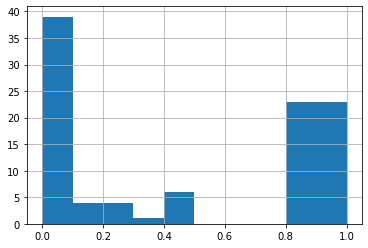

In [12]:
# Посмотрим не на сами классы, а на вероятности отнесения к класу
y_predicted_prob = best_clf.predict_proba(X_test) 
pd.Series(y_predicted_prob [:,1]).hist() #выводим в гистограмму

In [13]:
# Сдвигаем границу вероятности отнесения к класу
y_pred = np.where(y_predicted_prob[:,1]>0.1, 1, 0)
prec = precision_score(y_test,y_pred)
recal = recall_score(y_test,y_pred)
print(f'Точность - {prec} полнота - {recal}')
# Точность упала, зато полнота выросла

Точность - 0.819672131147541 полнота - 0.8620689655172413


In [14]:
# FN упал с 20 до 8 
confusion_matrix(y_test,y_pred)

array([[31, 11],
       [ 8, 50]], dtype=int64)

In [15]:
# Попробуем лес. Для примера с кросвалидацией 5
clf_rf = RandomForestClassifier()
parametrs = {'n_estimators': [10,20,30], 'max_depth': range(1,30)}
grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5)
grid_search_cv_clf.fit(X_train, y_train)
grid_search_cv_clf.best_params_

{'max_depth': 7, 'n_estimators': 30}

In [16]:
# Посмотрим как успехи
best_clf = grid_search_cv_clf.best_estimator_
best_clf.score(X_test, y_test)

0.84

In [32]:
# Еще метрики
y_pred = best_clf.predict(X_test)
prec = precision_score(y_test,y_pred)
recal = recall_score(y_test,y_pred)
print(f'Точность - {prec} полнота - {recal}')
# Тут уже лучше

Точность - 0.8333333333333334 полнота - 0.8620689655172413


In [17]:
confusion_matrix(y_test,y_pred)
# Здесь FP меньше, чем в итоговом дереве

array([[31, 11],
       [ 8, 50]], dtype=int64)

In [18]:
# Оставляем лучшую модель леса
# Заодно можем увидеть влияние признаков
feature_importances = best_clf.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_train),
                                    'feature_importances': feature_importances})
feature_importances_df.sort_values('feature_importances', ascending=False)

,features,feature_importances
11,ca,0.163749
2,cp,0.143337
12,thal,0.113757
7,thalach,0.104861
9,oldpeak,0.103460
0,age,0.079829
3,trestbps,0.072238
4,chol,0.063635
8,exang,0.052938
10,slope,0.043178


In [31]:
# Предскажем есть ли у человека заболевание:
X_test_one_person = data.head(1).drop(columns='target')
X_test_one_person


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1


In [32]:
best_clf.predict(X_test_one_person)
import pickle
pickle_out = open("best_clf.pkl","wb")
pickle.dump(best_clf, pickle_out)
pickle_out.close()

array([1], dtype=int64)